
# R : SDM : Varied Thrush 
-----------------------

BIO401-01/598-02 
 
Apr. 5 2021


## Preparation

R library that provides bindings to GDAL library. 

    $ conda install libgdal 
    $ R 
    > install.packages("rgdal",configure.args=c(rgdal = "--with-proj_api=proj.h"))
    > install.packages("dismo")
    > install.packages("caret")
    > install.packages("InformationValue")

In [3]:
library(raster)
library(dismo)
library(caret)
library(InformationValue)

In [4]:
set.seed(30)

## SDM 

types 
- Correlative 
- Mechanistic 

data 
- presence only 
- presence + absence 

## Species of Interest : Varied Thrush 

The varied thrush breeds in western North America from Alaska to northern California.

It is migratory, with northern breeders moving south within or somewhat beyond the breeding range.

Other populations may only move altitudinally.

<img src='./images/varied_thrush.jpg' width="400">

### Read in data 

In [16]:
vath.data <- read.csv("./txt/vath_2004.csv")
vath.val <- read.csv("./txt/vath_VALIDATION.csv")

In [3]:
head(vath.data)

,SURVEYID,TRANSECT,POINT,VATH,EASTING,NORTHING
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,452511619,3,0,59332.20,173289.0
2,2,452511619,5,0,59142.22,173151.8
3,3,452511619,6,0,58834.36,173185.7
4,4,452511619,9,0,58754.24,172876.0
5,5,452511625,1,0,59037.42,181450.2
6,6,452511625,4,0,59336.71,181389.1


In [17]:
# split dataset by presence 
vath.pres <- vath.data[vath.data$VATH==1,]
vath.abs <- vath.data[vath.data$VATH==0,] 
vath.pres.xy <- as.matrix(vath.pres[,c("EASTING","NORTHING")]) 
vath.abs.xy <- as.matrix(vath.abs[,c("EASTING","NORTHING")])

In [18]:
# validation dataset
vath.val.pres <- as.matrix(vath.val[vath.val$VATH==1, c("EASTING","NORTHING")]) 
vath.val.abs <- as.matrix(vath.val[vath.val$VATH==0, c("EASTING","NORTHING")]) 
vath.val.xy <- as.matrix(vath.val[,c("EASTING","NORTHING")])

In [16]:
head(vath.val.pres)

,EASTING,NORTHING
97,257608.84,260574.5
151,72212.39,355337.3
152,72305.07,355535.5
154,156539.72,354851.7
155,156770.04,354898.6
164,54244.40,366721.0


In [5]:
# env layers 
elev <- raster("./R_db/elev.gri") # elevation
canopy <- raster("./R_db/cc2.gri") # canopy slope 
mesic <- raster("./R_db/mesic.gri") # mesic forest 
precip <- raster("./R_db/precip.gri") # precipitation

In [23]:
#check maps 
compareRaster(elev, canopy) 

[1] TRUE

In [26]:
compareRaster(elev, mesic)

ERROR: Error in compareRaster(elev, mesic): different extent


In [6]:
elev

class      : RasterLayer 
dimensions : 2083, 1643, 3422369  (nrow, ncol, ncell)
resolution : 200, 200  (x, y)
extent     : 19165, 347765, 164300, 580900  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : /home/user/SE_data/exercise/R_db/elev.grd 
names      : elev_km 
values     : 0, 3.079  (min, max)


In [7]:
mesic

class      : RasterLayer 
dimensions : 2050, 1586, 3251300  (nrow, ncol, ncell)
resolution : 210, 210  (x, y)
extent     : 16965, 350025, 153735, 584235  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_1=46 +lat_2=48 +lat_0=44 +lon_0=-109.5 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : /home/user/SE_data/exercise/R_db/mesic.grd 
names      : a_pmesic 
values     : 0, 1  (min, max)


In [8]:
precip

class      : RasterLayer 
dimensions : 2152, 1664, 3580928  (nrow, ncol, ncell)
resolution : 200, 200  (x, y)
extent     : 16965, 349765, 153735, 584135  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_1=46 +lat_2=48 +lat_0=44 +lon_0=-109.5 +x_0=600000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 
source     : /home/user/SE_data/exercise/R_db/precip.grd 
names      : ppt_cm 
values     : 23, 287  (min, max)


Interpolation

<img src='./images/interpolation.png' width="800">

In [5]:
# resampling 
mesic <- resample(x=mesic, y=elev, "ngb")
precip <- resample(x=precip, y=elev, "bilinear")

In [6]:
#crop to same extent 
mesic <- mask(mesic, elev) 
precip <- mask(precip, elev)

In [7]:
compareRaster(elev,precip, mesic)

[1] TRUE

In [10]:
# creat a forest layer at 1km resolution 
fw.1km <- focalWeight(mesic, 1000, 'circle')
mesic1km <- focal(mesic, w=fw.1km, fun="mean", na.rm=T)

In [42]:
#create raster stacck 
layers <- stack(canopy, elev, mesic, mesic1km, precip) 
names(layers) <- c("canopy", "elev", "mesic", "mesic1km", "precip")

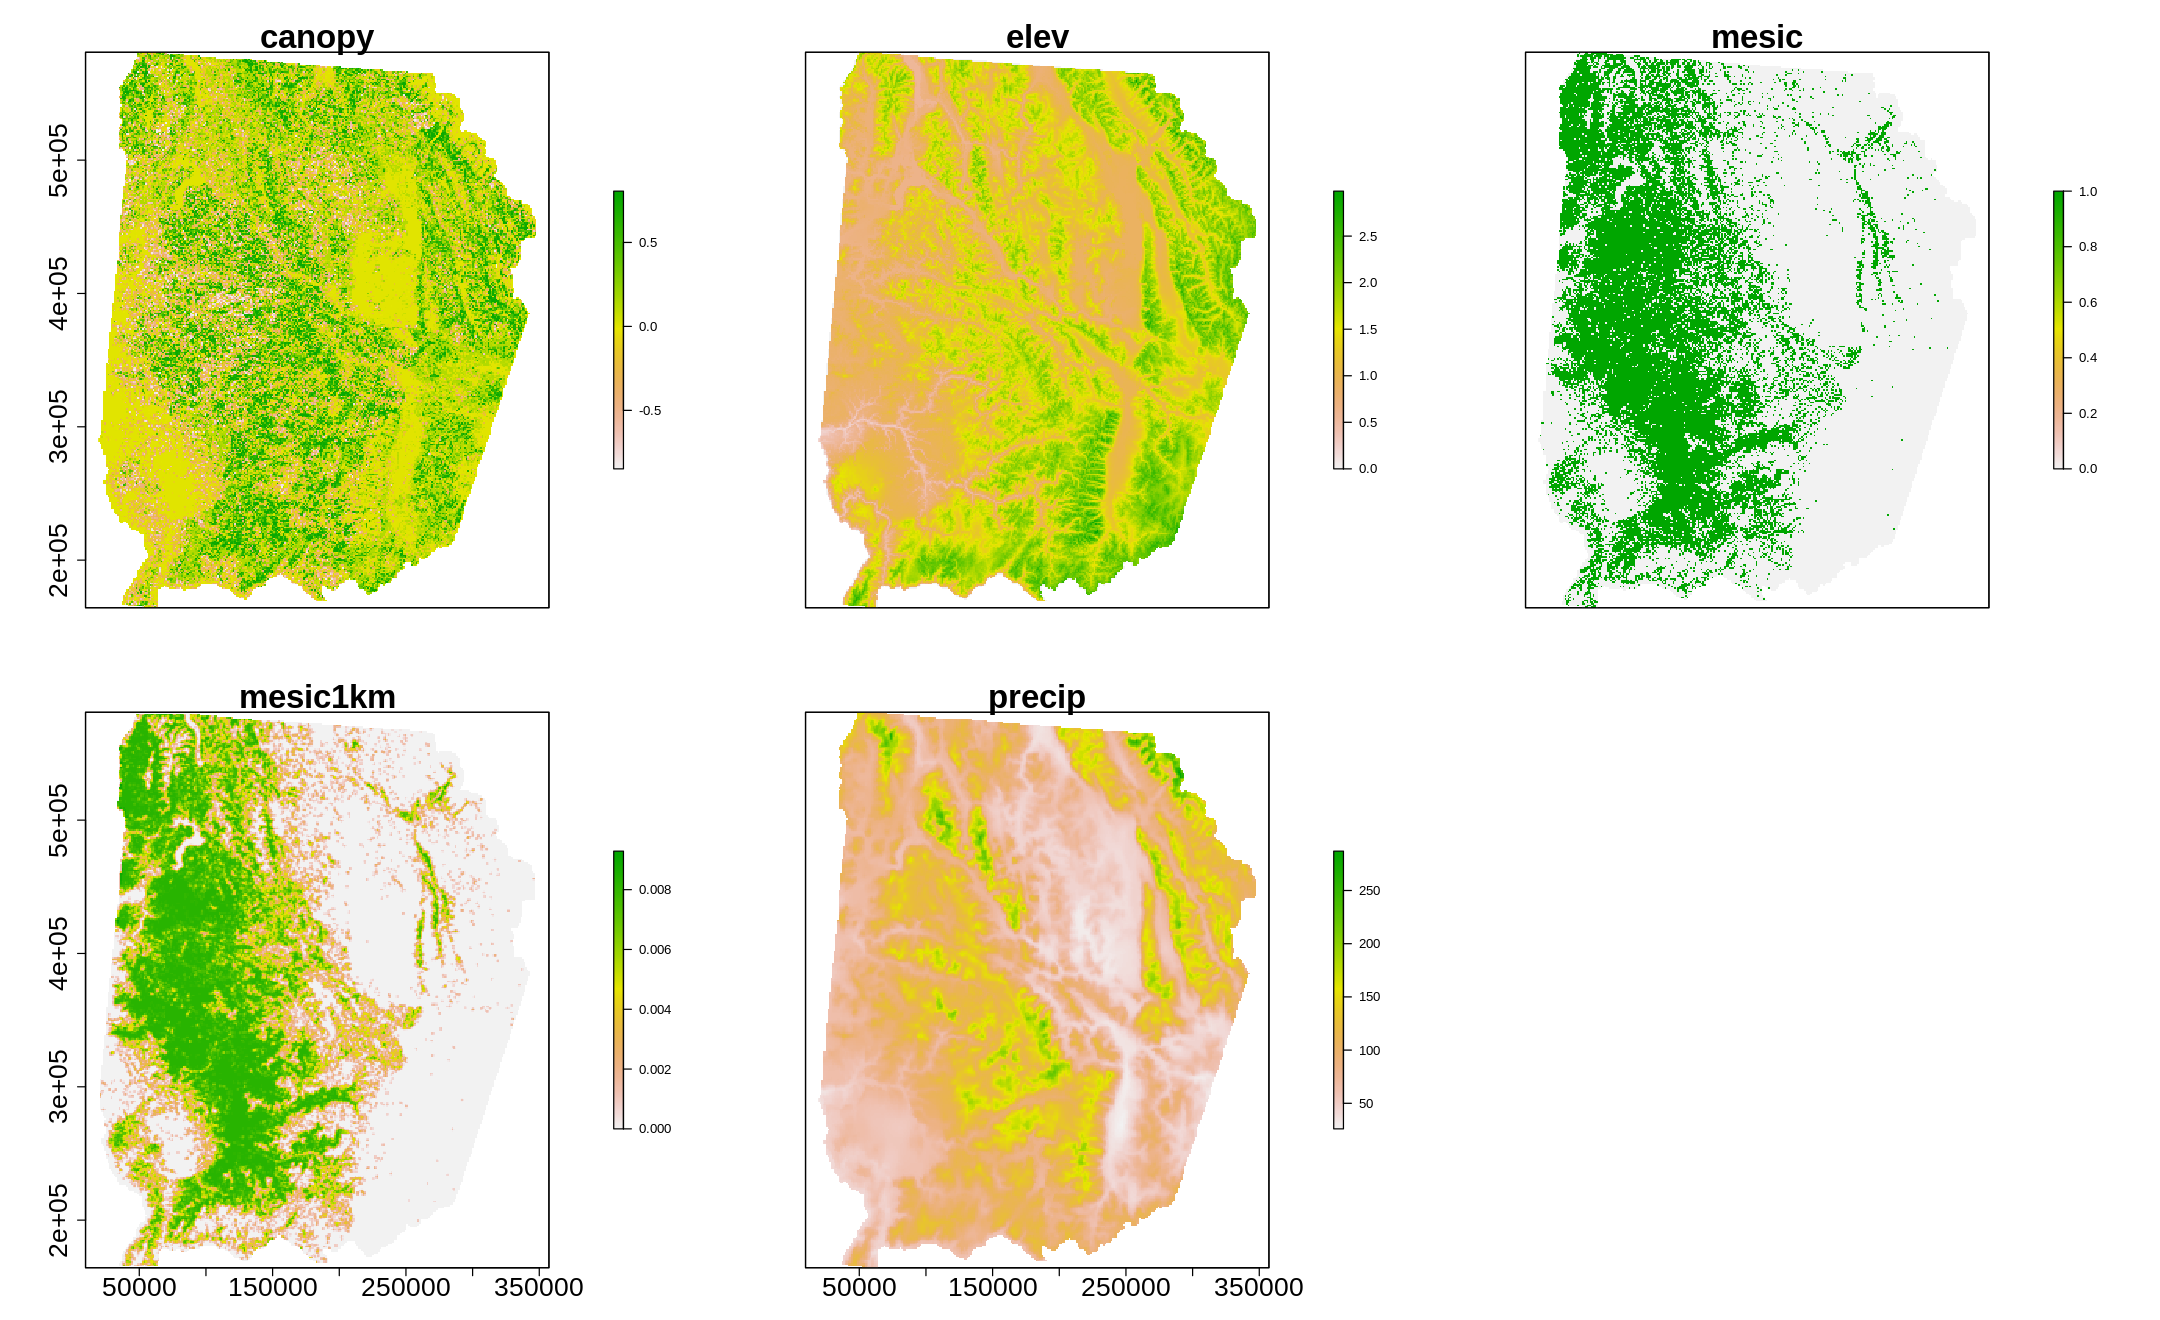

In [50]:
options(repr.plot.width=18, repr.plot.height=11)
plot(layers,cex.axis=2,cex.lab=2,cex.main=2.5,legend.args=list(text=NULL, side=1, cex.lab = 3, line=2.3))

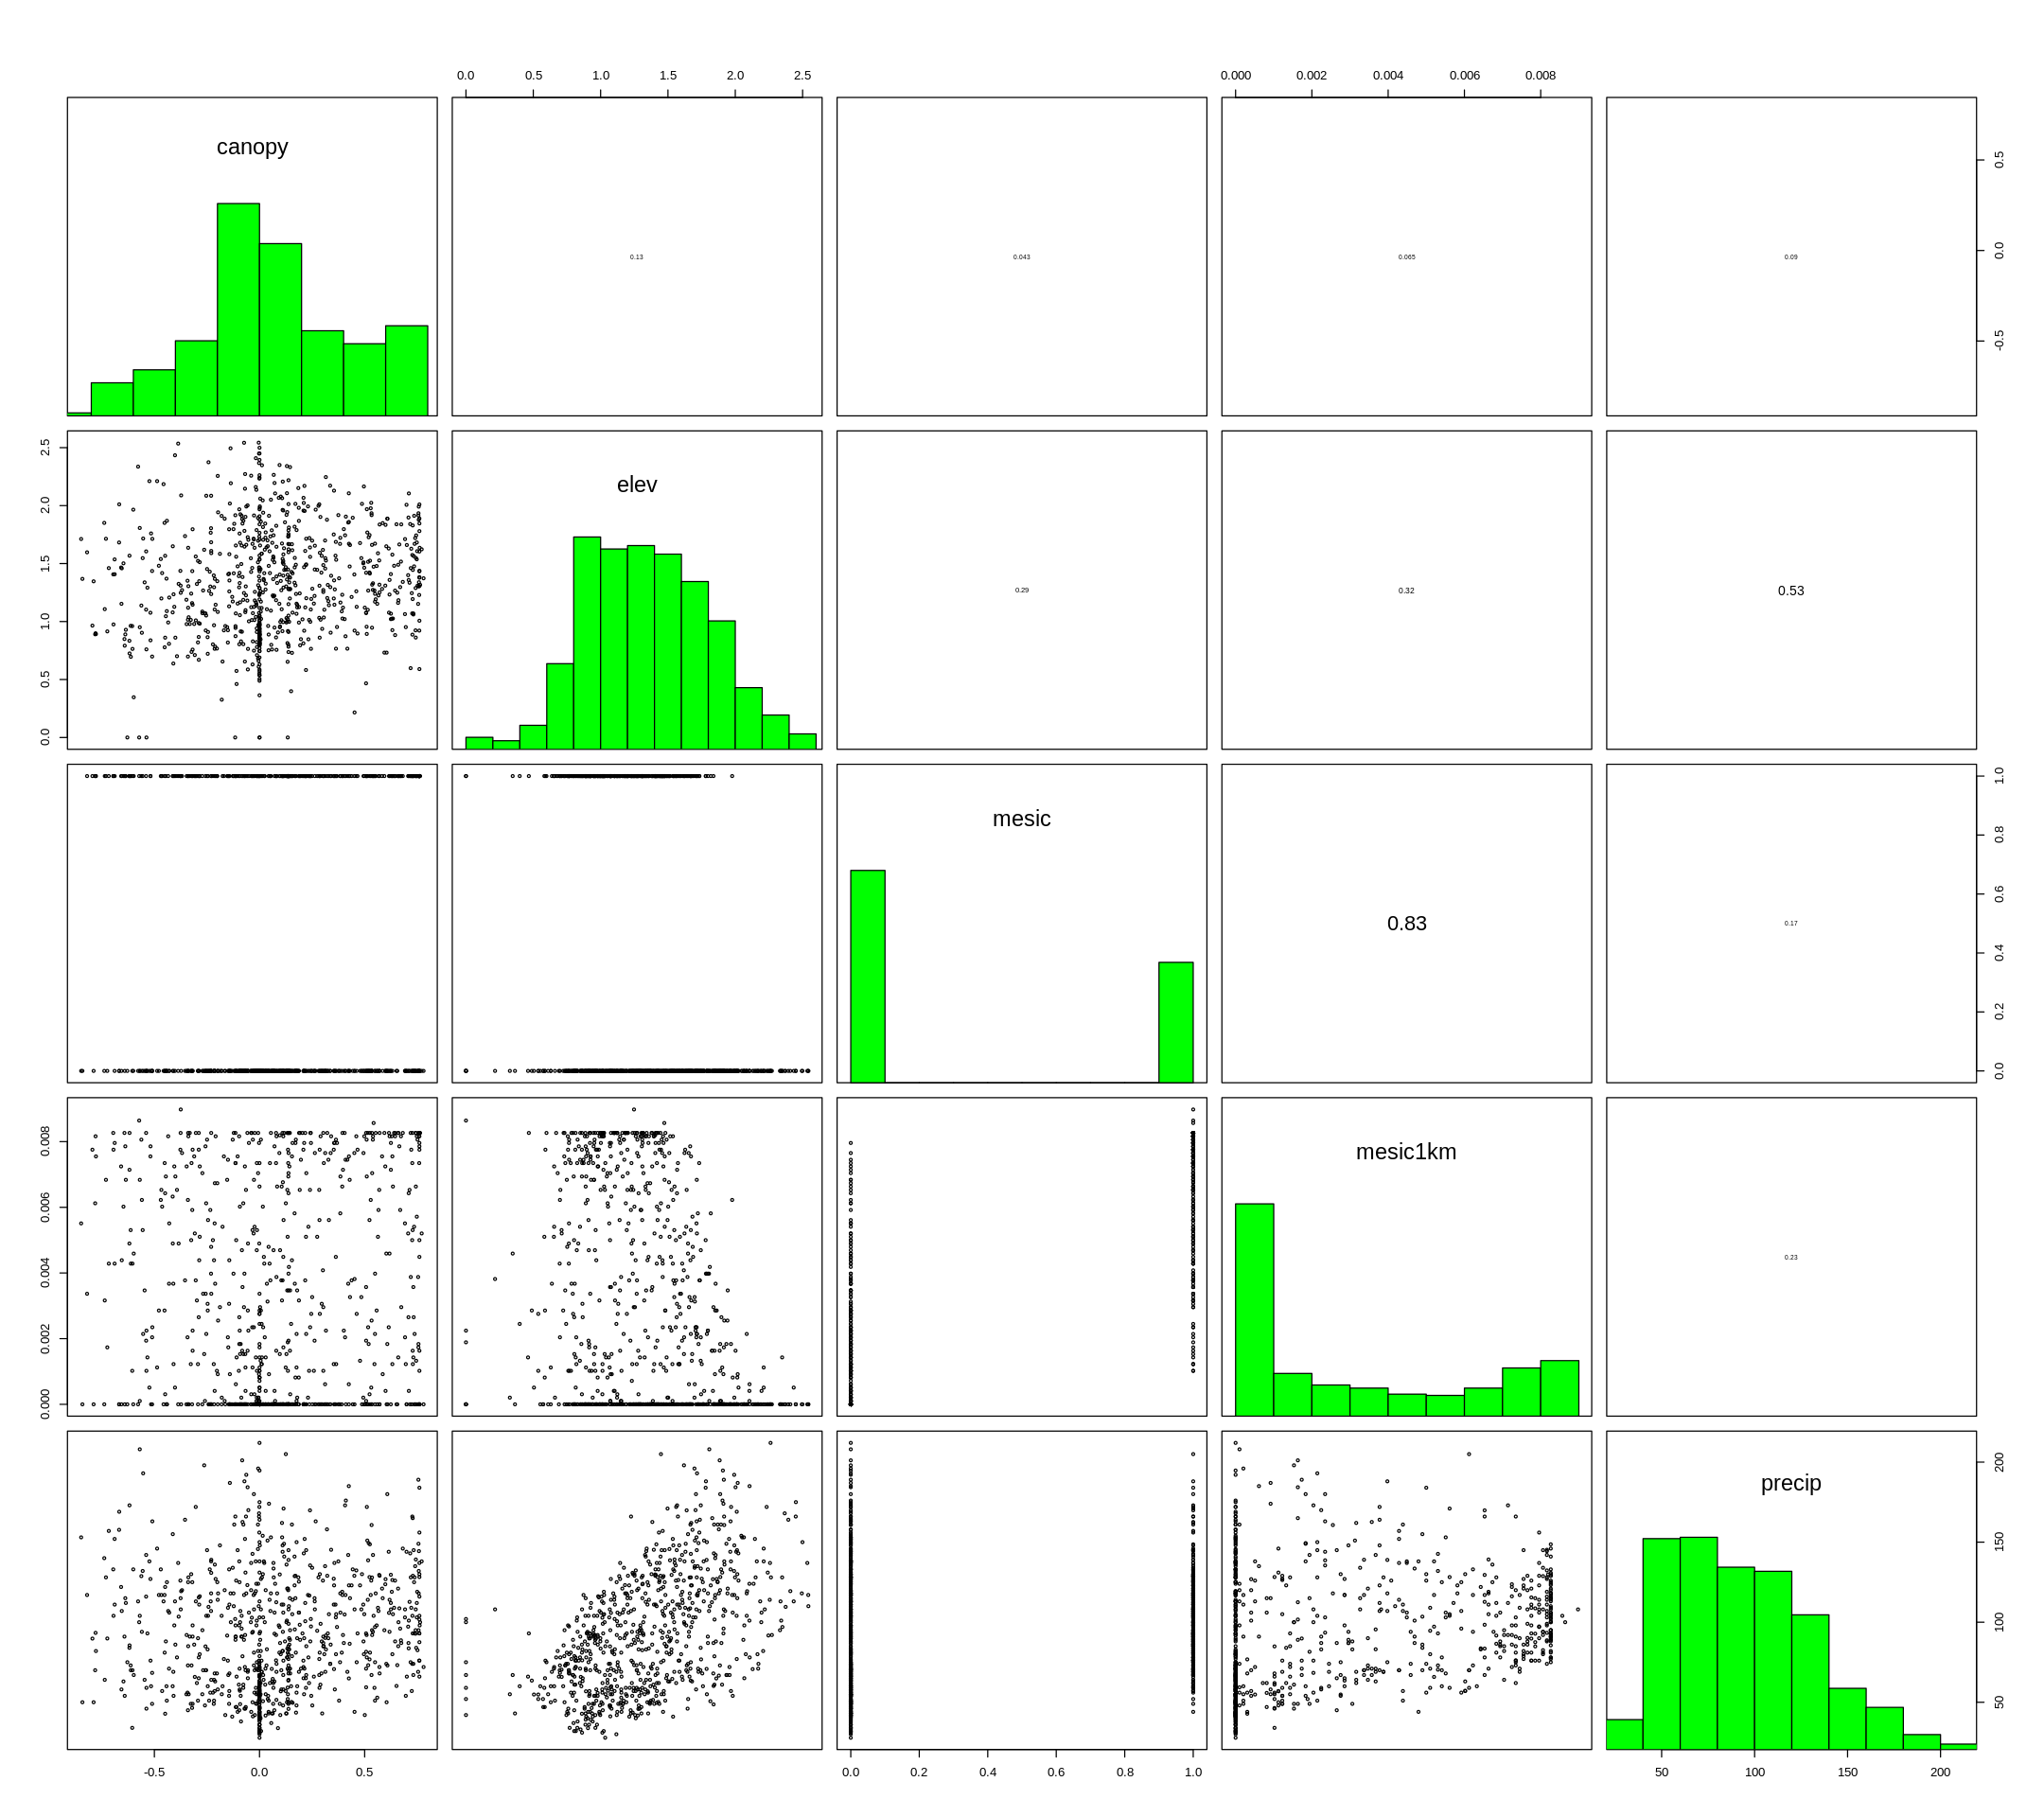

In [13]:
options(repr.plot.width=18, repr.plot.height=16)
pairs(layers,maxpixels=1000,cex=0.5)

In [14]:
#drop correlated layer (mesic) 

layers <- dropLayer(layers, 3)

In [19]:
#Generate background points using 
# 2000 was chosen for the illustration purpose. 
# This number can be much larger in real practice. 

back.xy <- randomPoints(layers, p=vath.pres.xy, n=2000)
colnames(back.xy) <- c("EASTING","NORTHING")

In [74]:
head(back.xy)

x,y
124065,226200
152665,317400
152465,250400
139265,258400
181465,378800
59665,423800


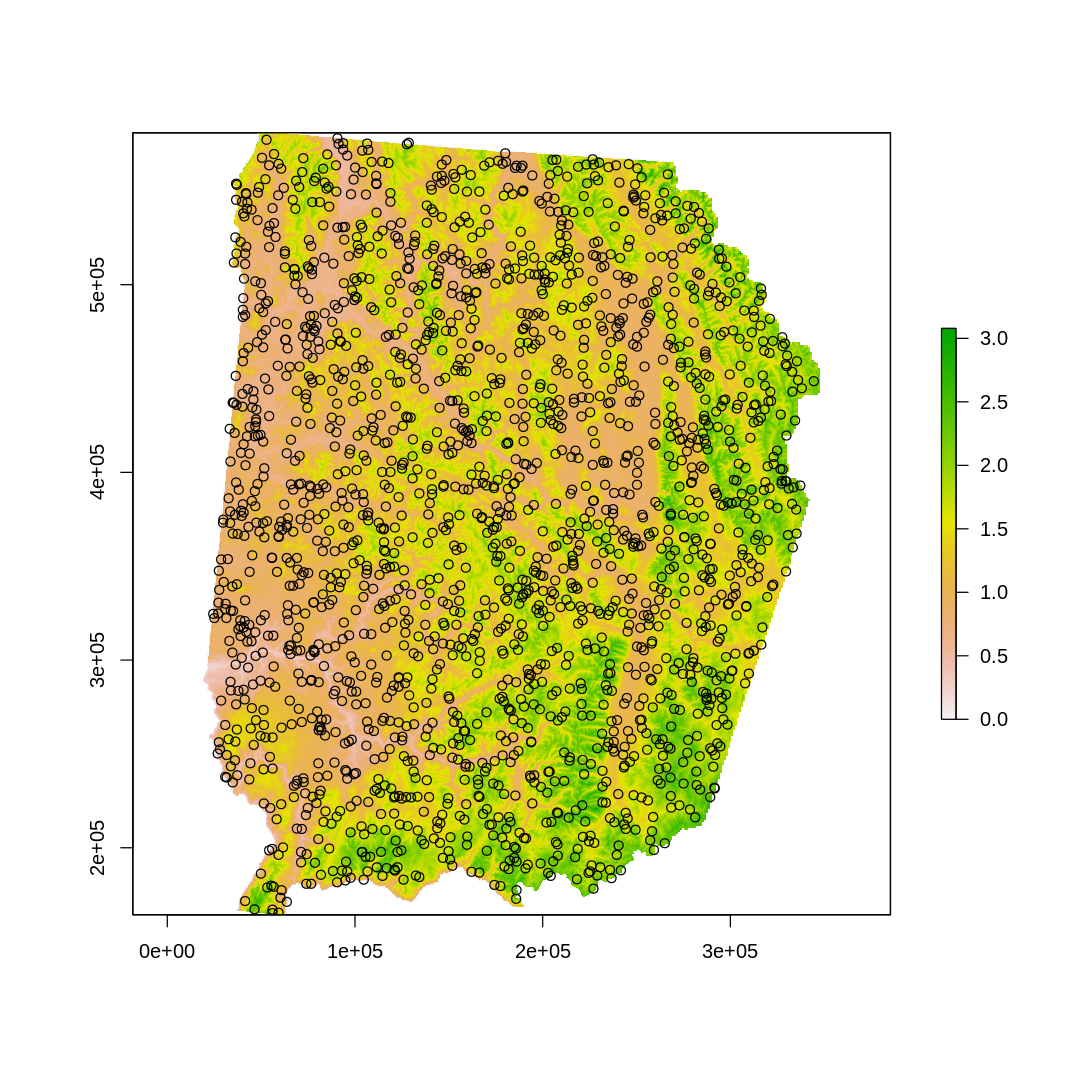

In [20]:
options(repr.plot.width=9, repr.plot.height=9)
plot(elev)
points(back.xy)

In [21]:
#extract GIS data 
pres.idpv <- extract(layers, vath.pres.xy)          
back.idpv <- extract(layers, back.xy)           
val.idpv <- extract(layers, vath.val.xy)            

In [22]:
#link data 
df.pres <- data.frame(vath.pres.xy, pres.idpv, pres=1) 
df.back <- data.frame(back.xy, back.idpv, pres=0) 
df.val <- data.frame(vath.val, val.idpv)

In [87]:
head(df.pres)

,EASTING,NORTHING,canopy,elev,mesic1km,precip,pres
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,95880.25,191274.0,0.03908799,2.033,0.1481481,126.000,1
38,90821.05,210968.8,-0.13464460,1.682,0.3950617,104.000,1
39,90745.12,210715.3,0.32875299,1.665,0.4691358,104.000,1
42,90463.29,209767.5,0.22702400,1.676,0.7530864,106.000,1
43,90142.26,209555.8,0.43240750,1.659,0.8148148,106.000,1
48,116258.21,216962.9,0.59498268,1.497,1.0000000,85.875,1


In [23]:
#remove any potential NAs 
df.pres <- df.pres[complete.cases(df.pres),] 
df.back <- df.back[complete.cases(df.back),] 
df.val <- df.val[complete.cases(df.val),]

In [24]:
# merge together 
df.all <- rbind(df.pres, df.back)

In [90]:
head(df.all)

,EASTING,NORTHING,canopy,elev,mesic1km,precip,pres
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,95880.25,191274.0,0.03908799,2.033,0.1481481,126.000,1
38,90821.05,210968.8,-0.13464460,1.682,0.3950617,104.000,1
39,90745.12,210715.3,0.32875299,1.665,0.4691358,104.000,1
42,90463.29,209767.5,0.22702400,1.676,0.7530864,106.000,1
43,90142.26,209555.8,0.43240750,1.659,0.8148148,106.000,1
48,116258.21,216962.9,0.59498268,1.497,1.0000000,85.875,1


In [25]:
# data transformation 
# Scaling and centering the environmental variables to zero mean and variance of 1
predictors <- c("canopy","elev","mesic1km","precip")
df.all[,predictors] <- scale(df.all[,predictors])

In [94]:
head(df.all)

,EASTING,NORTHING,canopy,elev,mesic1km,precip,pres
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
22,95880.25,191274.0,-0.1392220,1.5492040,-0.609419480,0.8536111,1
38,90821.05,210968.8,-0.6450800,0.7652292,0.009843172,0.2539466,1
39,90745.12,210715.3,0.7041968,0.7272587,0.195621968,0.2539466,1
42,90463.29,209767.5,0.4079921,0.7518278,0.907774019,0.3084616,1
43,90142.26,209555.8,1.0060081,0.7138576,1.062589682,0.3084616,1
48,116258.21,216962.9,1.4793790,0.3520229,1.527036672,-0.2400951,1


### Model Fitting

generalized linear model 

1. An exponential family of probability distributions.

2. A linear predictor $\displaystyle \eta =X\beta$

3. A link function ${\displaystyle g}$ such that ${\displaystyle E(Y\mid X)=\mu =g^{-1}(\eta )}$

In [26]:
mdl.vath <- glm(pres~canopy+elev+I(elev^2)+mesic1km+precip, family=binomial(link=logit), data=df.all)

In [27]:
summary(mdl.vath)


Call:
glm(formula = pres ~ canopy + elev + I(elev^2) + mesic1km + precip, 
    family = binomial(link = logit), data = df.all)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7757  -0.3423  -0.2126  -0.1371   3.5321  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.85830    0.17404 -16.424  < 2e-16 ***
canopy       0.19543    0.09928   1.968  0.04901 *  
elev        -0.72618    0.27404  -2.650  0.00805 ** 
I(elev^2)   -0.97856    0.24709  -3.960 7.49e-05 ***
mesic1km     0.39188    0.15197   2.579  0.00992 ** 
precip       0.49281    0.16762   2.940  0.00328 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 773.28  on 2093  degrees of freedom
Residual deviance: 674.77  on 2088  degrees of freedom
AIC: 686.77

Number of Fisher Scoring iterations: 8


### Model Evaluation 

In [28]:
df.val[,predictors] <- scale(df.val[,predictors])

In [29]:
df.val$pred <- predict(mdl.vath,df.val[,predictors],type="response")

In [30]:
head(df.val)

,X.1,X,TRANSECT,STOP,YEAR,VATH,EASTING,NORTHING,canopy,elev,mesic1km,precip,pred
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,464811437,2,2007,0,209685.9,325750.0,0.74425510,-0.5121329,-0.1800319,-1.1350612,0.0381429149
2,2,2,464811437,3,2007,0,209845.0,325979.0,0.44215351,-0.5299351,-0.2678732,-1.1350612,0.0346827307
3,3,3,464811437,6,2007,0,210406.8,326674.1,0.50654501,-0.4705947,-0.7070799,-1.1045330,0.0305994483
4,4,4,454311415,3,2007,0,230797.4,201486.2,-0.92568323,1.5855534,-1.0877256,-0.4319874,0.0006819783
5,5,5,454311415,4,2007,0,231006.4,201499.1,-0.60895621,1.5291802,-1.0877256,-0.4319874,0.0008973454
6,6,6,454311415,6,2007,0,231491.6,201433.0,0.01492895,1.7784102,-1.0877256,-0.3209758,0.0003989799


confusion matrix 

<img src='./images/confusion_matrix.png' width="900">

In [31]:
cutoff <- optimalCutoff(df.val$VATH, df.val$pred)

In [32]:
df.val[which(df.val$pred>=cutoff),]

,X.1,X,TRANSECT,STOP,YEAR,VATH,EASTING,NORTHING,canopy,elev,mesic1km,precip,pred
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1555,1557,1557,471011616,12,2008,1,87299.98,374993.7,1.695836,-0.26587,1.28399,1.751242,0.2617735


In [33]:
confusionMatrix(df.val$VATH,df.val$pred,threshold=cutoff)

,0,1
,<int>,<int>
0,1763,148
1,0,1


In [129]:
specificity(df.val$VATH,df.val$pred,threshold=cutoff)

[1] 1

In [130]:
sensitivity(df.val$VATH,df.val$pred,threshold=cutoff)

[1] 0.006711409

In [140]:
# Calculate the percentage misclassification error for the given actuals and probaility scores.
misClassError(df.val$VATH,df.val$pred,threshold=cutoff)

[1] 0.0774

ROC curves

<img src='./images/ROC_curves.png' width="600">

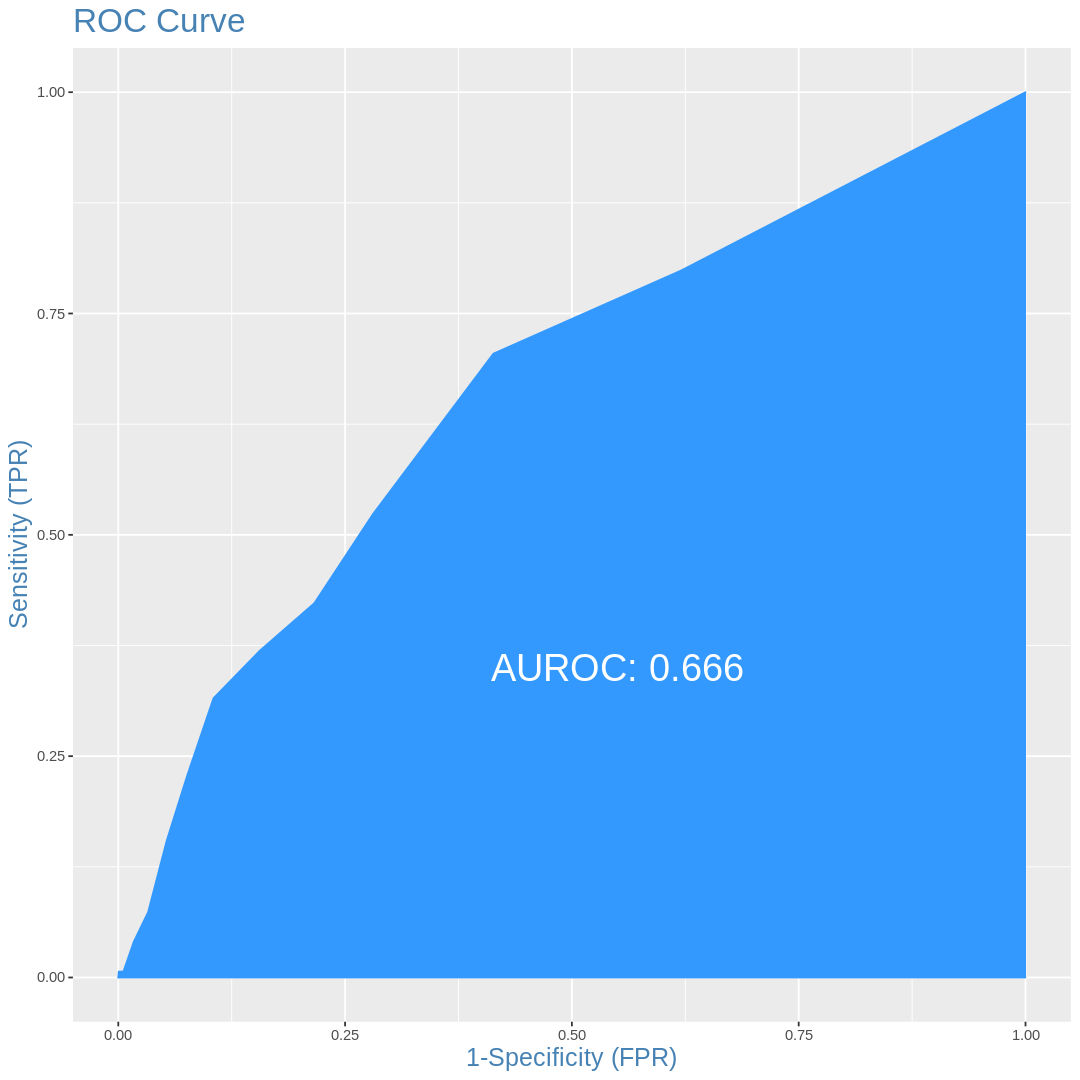

In [141]:
plotROC(df.val$VATH,df.val$pred)

## Discussions 

1. HW vs. Project 

2. Future course topics 
    - thematic subjects : eg. GLM, Bayesian, etc.
    - data techniques : eg. transformations, sampling, etc.  
    - case studies 
    - others ? 
 
 
  

<div class="alert alert-block alert-info">
<b>Feedback :  Please Provide input via slack channel by 4pm Apr 8. (EDT) </b>
</div>

## References 

    - Geocomputation with R. https://geocompr.robinlovelace.net/
    - Spatial Data Science with R. https://www.rspatial.org/
    - M. Stevens. A Primer Of Ecology With R (2009) 
    - D. Borcard, F. Gillet, and P. Legendre. Numerical Ecology with R (2018)
    - R. Fletcher and M. Fortin. Spatial Ecology and Conservation Modeling Applications with R (2018)
    - Spatial Modeling in GIS and R for Earth and Environmental Sciences (2019) ISBN : 978-0128152263
    - https://en.wikipedia.org/wiki/Varied_thrush
    - https://en.wikipedia.org/wiki/Mesic_habitat
    - https://en.wikipedia.org/wiki/Generalized_linear_model
    - https://en.wikipedia.org/wiki/Binomial_distribution
    - https://en.wikipedia.org/wiki/Receiver_operating_characteristic
    - https://en.wikipedia.org/wiki/Bilinear_interpolation
    - https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation